# Questions
- the text data file has 625 respondents; # data file has 583 -- need them to be downloaded at the same exact time to match

# Progress updates
    - 6/10 - cleaning up look of histograms/ finishing testing functionality, mapping text data
    - 6/16 - t-value calculations

# Notes
    - focus on getting histograms and t-tests for all the questions as they relate to the demographics so that we can get a sense of the data. Then get into linear regressions after that.

In [726]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import math
from collections import OrderedDict

In [179]:
matplotlib.rcParams['figure.figsize'] = [10, 8]

# Methods

In [108]:
#src: https://www.geeksforgeeks.org/counting-the-frequencies-in-a-list-using-dictionary-in-python/
def CountFrequency(my_list):
    # Creating an empty dictionary
    count = {}
    
    for i in my_list:
        count[i] = count.get(i, 0) + 1
    return count

In [69]:
def create_column_mapping(df, columns_text_list):
    ## returns: a dict with the keys = textual column labels
    ##     and values = raw data column labels 
    
    assert(type(df) == pd.core.frame.DataFrame)
    assert(type(columns_text_list) == list)
    
    raw_columns = pd.Index.tolist(df.columns)
    
    ## zip(keys, vals)
    return dict(zip(columns_text_list, raw_columns))
    
    

In [702]:
def create_question_answer_text_mapping(data, text_data, question_text):
    # 1 - go through each question. get all the potential responses
    # 2 - get their location in the dataframe
    # 3 - go into the text_data dataframe with that index 
    # 4 - map the raw data to the text data in a dictionary & return it
    
    # returns: a dict with the keys = raw column labels 
    #                          values = list[2] with [0] = textual column label + [1] a dict of the Q's answers,
    #                          with the keys = raw answers, values = textual answers
    
    assert(type(data) == pd.core.frame.DataFrame)
    assert(type(text_data) == pd.core.frame.DataFrame)
    
    tt = {k:[question_text[k], {}] for k in question_text.keys()}
    # get the unique vals for each Q
    ll = {col:[data.loc[:,col].unique()] for col in data.columns}
    ## not working randomly? kk = {k: {for i in a[0]} for q,a in ll.items()}
    kk = {}
    for q,a in ll.items():
        for i in a[0]:
            kk[q] = a[0]
            
    my_keys = list(ll.keys())[17:28]
    my_keys.extend(list(ll.keys())[28::5])
    my_keys.remove('I03')
    
    for q,a in ll.items():
        if q in my_keys:
            xx = tt[q][1]
            for i in a[0]:
                xx[i] = text_data[q][data[data[q]==i].index.values[0]]
                
    return tt

In [335]:
def clean_raw_data(df, elim_top_rows = 0, elim_every_other = False):
    ## returns: a dataframe containing only 
    ##      relevant rows from the raw data
    assert(type(df) == pd.core.frame.DataFrame)
    
    ## clean up extraneous top x rows
    data_temp = df.iloc[elim_top_rows:df.index.size]
    if elim_every_other == True:
        ## every other row in the raw data is blank. clean that up
        data_temp = data_temp.iloc[::2]
    return data_temp
    

In [307]:
def convert_data_types(df):
    ## df - dataframe
    ## NOTE: THIS OPERATES ON THE DATAFRAME IN PLACE
    for i in range(0,len(df.columns)):
        tempcol = df[df.columns[i]]
        testind = tempcol.index[0]
        
        try:
            float(tempcol[testind])
            df[df.columns[i]] = df[df.columns[i]].astype(float)
        except:
            #this doesnt seem to be working? (dont know if it matters) 
            df[df.columns[i]] = df[df.columns[i]].astype(str)    

In [807]:
def generate_x_axis_labels_hist(x_title, text_mapping, include_non_answers):
    
    data = dict(OrderedDict(sorted(text_mapping[x_title][1].items())))
    labels = []
    if float(0) in data.keys():
        data.pop(float(0))
    if include_non_answers == True:
        labels.append("No Response")
        
    s = " "
    for k,v in data.items():
        if len(str(v)) > 3: #4 is an arbitrary thresh, should work tho
            labels.append(v)
        else:
            s = s + " "
            labels.append(s)
            
    return labels
        

In [526]:
# this version of the histogram is for continuous data only (i.e. age)
# NEED TO FINISH 
def create_histogram_continuous(data, x_title, mapping, numbins=10, prob=True, include_non_answers=False, show_mean=False, 
                     show_resp_row_num=-1):
    
    t = mapping[x_title]
                          
    ## get the x data column from the dataframe
    data_col = pd.DataFrame(data, columns=[t])
    
    flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]
        
    ## THIS IS THE DIFFERENCE IN THIS METHOD 
    res = stats.binned_statistic(flat_list, flat_list, statistic='count', bins=numbins)
    counts = res[0]
    labels = res[1]
    
    # in the main code we replaced the NaNs with 0's, 
    # so here, we just eliminate that info from our hist before making graph
    if include_non_answers == False:
        labels = labels[1:len(labels)]
        counts = counts[1:len(counts)]
        
    fig, ax = plt.subplots()
    
    if prob == True:
        total = np.sum(counts)
        counts = [float(i) for i in counts]
        counts[:] = [x / total for x in counts]
        ax.set_ylabel("Probability")
    else:
        ax.set_ylabel("Frequency")
    
    # make range labels
    rangelabels = []
    for i in range(1, len(labels)):
        rangelabels.append("{:.1f}".format(labels[i-1])+" - "+"{:.1f}".format(labels[i]))
        
    ax.bar(rangelabels, counts, align='center')
    fig.gca().set_xticks(rangelabels)
    ax.set_xlabel(x_title)
    plt.xticks(rotation=45)
    
    # NEED TO FIX THIS FUNCTIONALITY FOR THE BINNED DATA
    if show_mean == True:
        mean = np.mean(flat_list)
        #ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        #min_ylim, max_ylim = plt.ylim()
        ax.text(mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean))
    if show_resp_row_num > -1 and show_resp_row_num < len(flat_list)-1:
        resp = flat_list[show_resp_row_num]
        #ax.axvline(resp, color='k', linestyle='solid', linewidth=1)
        #min_ylim, max_ylim = plt.ylim()
        ax.text(resp*1.1, max_ylim*0.9, 'User {:}: {:}'.format(show_resp_row_num, resp))
    
    plt.show()

In [840]:
def create_histogram(data, x_title, mapping, text_mapping, prob=True, include_non_answers=False, show_mean=False, 
                     show_resp_row_num=-1):
    ## data -- clean data dataframe 
    ## x_title -- string
    ## include_non_answers -- boolean; includes people that didnt respond to the Q in the hist
    ## prob -- boolean; if true, show %'s, if false, show frequency
    ## mapping -- the column mapping returned from create_column_mapping
    ## show_mean -- boolean, shows the average from the histogram
    ## show_resp_row_num -- integer [0-# responses-1], the row number of the respondent whose answer you want to display
    
    t = mapping[x_title]
    ## get the x data column from the dataframe
    data_col = pd.DataFrame(data, columns=[t])
    question_text = text_mapping[t][0]
    
    flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]
    
    labels, counts = np.unique(flat_list, return_counts=True)
    
    # in the main code we replaced the NaNs with 0's, 
    # so here, we just eliminate that info from our hist before making graph
    if include_non_answers == False:
        labels = labels[1:len(labels)]
        counts = counts[1:len(counts)]
        
    fig, ax = plt.subplots()
    
    
    if prob == True:
        total = np.sum(counts)
        counts = [float(i) for i in counts]
        counts[:] = [x / total for x in counts]
        ax.set_ylabel("Probability")
    else:
        ax.set_ylabel("Frequency")
        
    x_axis_labels = generate_x_axis_labels_hist(t, text_mapping, include_non_answers)
    ax.bar(x_axis_labels, counts, align='center')
    fig.gca().set_xticks(x_axis_labels)
    plt.xticks(rotation=45)

    if len(question_text) > 50:
        plt.title(x_title +" - " + question_text.split(" ", 2)[0])
    else:
        plt.title(question_text)
        
    ax.set_xlabel('Responses')
    print(question_text)
    
    if show_mean == True:
        if include_non_answers == False:
            mean = np.mean(flat_list)
        else:
            temp = list(filter((0.0).__ne__, flat_list))
            temp = list(filter((0).__ne__, flat_list))
            mean = np.mean(flat_list)          
        ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        ax.text(mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean))
    if show_resp_row_num > -1 and show_resp_row_num < len(flat_list)-1:
        resp = flat_list[show_resp_row_num]
        ax.axvline(resp, color='k', linestyle='solid', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        ax.text(resp*1.1, max_ylim*0.9, 'User {:}: {:}'.format(show_resp_row_num, resp))
    
    plt.show()

In [828]:
def calculate_t_test(data, mapping, a_name, b_name, equal_var=False, nan_policy='omit'):
    ## see scipy.stats.ttest_ind
    
    t_a = mapping[a_name]
    t_b = mapping[b_name]
    ## get the data columns from the dataframe
    data_col_a = pd.DataFrame(data, columns=[t_a])
    data_col_b = pd.DataFrame(data, columns=[t_b])
    
    flat_list_a = [item for sublist in pd.Index.tolist(data_col_a) for item in sublist]
    flat_list_b = [item for sublist in pd.Index.tolist(data_col_b) for item in sublist]
    
    return stats.ttest_ind(flat_list_a, flat_list_b, equal_var=equal_var, nan_policy=nan_policy)

# Main Code

### Settings

In [45]:
## show more items when printing for debugging purposes
pd.options.display.max_seq_items = 2000
pd.options.display.max_columns = 2000

### Read in and clean the data

In [660]:
## raw_data is of type(pandas.core.frame.DataFrame) -- 
## "DataFrame is a 2-dimensional labeled data structure 
## with columns of potentially different types. 
## You can think of it like a spreadsheet or SQL table, or a dict of Series objects."

## import the data file
raw_data = pd.read_csv('../Ethics_June+24,+2020_03.36 (1).csv')

## import the raw corresponding text answers
raw_text_data = pd.read_csv('../Ethics_June+24,+2020_03.36.csv')

In [661]:
# clean the # data and text data
data = clean_raw_data(raw_data, 5, True)
text_data = clean_raw_data(raw_text_data, 2, False)

In [662]:
# change the data types to floats (where applicable)
convert_data_types(data)

In [663]:
# replace the NaNs with 0's -- doing this for easier analyzations. this can be applied
# selectively to certain columns if we run into problems bc of this change
data.replace({np.NaN : 0}, inplace=True)

### Make some mappings between text descriptors and data for easier readability

In [664]:
# store the question text dict
question_text = raw_text_data.iloc[0, :].to_dict()

In [833]:
# create the mapping between textual column names and non-descriptive column names
# as is this is line is not doing anything, we can pass a list of titles as the last arg
# however, which will name the columns whatever you want to name them.
column_mapping = create_column_mapping(data,pd.Index.tolist(data.columns))

In [834]:
# hard coding this part for the column mapping
#column_mapping['Gender'] = column_mapping.pop('I02')
#column_mapping['Age'] = column_mapping.pop('I03')
#column_mapping['Race-Ethnicity'] = column_mapping.pop('I04')
#column_mapping['Education'] = column_mapping.pop('I05')
#column_mapping['Nationality'] = column_mapping.pop('I06')
#column_mapping['Income'] = column_mapping.pop('I07')

In [705]:
text_mapping = create_question_answer_text_mapping(data, text_data, question_text)

## Example of how to use the histogram function!

CONSCIOUSNESS Imagine that neuroscientists were able to create a full replica of your brain. Every neuron, every synapse, and every molecule are duplicated in a nearby clone. With this replication, every thought, idea, feeling and experience you go through will also be shared by the clone.  However, since the scientists cannot allow for the two clones to co-exist, once the replication is complete you are offered a large sum of money (say, $10,000,000) in return for letting the experimenters kill you. The clone will leave with the money and all your thoughts in the replicated brain, but you will be killed. Will you accept this offer to be killed in return for the money that will be given to your identical clone? - 1


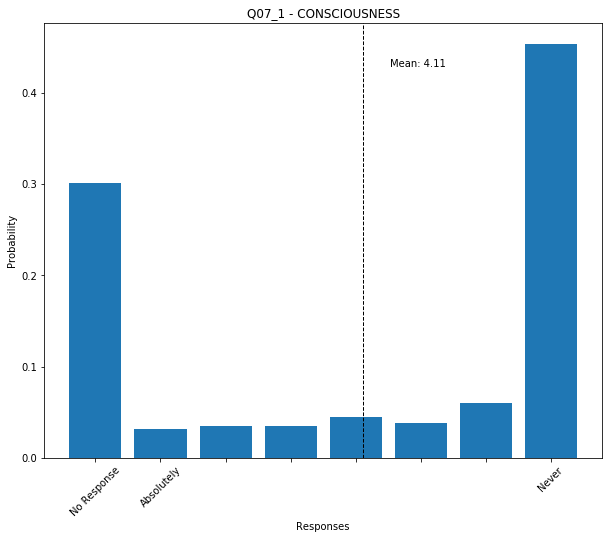

In [831]:
# this function is for categorical histogram data
create_histogram(data, 'Q07_1', column_mapping, text_mapping, prob=True, include_non_answers=True, 
                show_mean=True, show_resp_row_num=387)

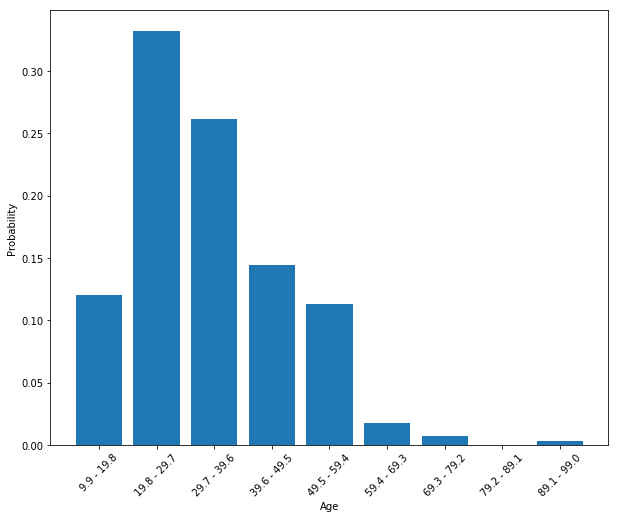

In [799]:
# this is the continuous histogram function -- it manually bins continuous data
create_histogram_continuous(data, 'Age', column_mapping, prob=True, include_non_answers=False, show_mean=False)



### Example of how to use t value calculation function

In [670]:
res = calculate_t_test(data, column_mapping, 'Gender', 'Q01_1')
print(res)

Ttest_indResult(statistic=-8.913273879644763, pvalue=2.5838160832314346e-17)


## Make all of the single bar histograms

In [ ]:
# this function is for categorical histogram data
create_histogram(data, 'Q07_1', column_mapping, text_mapping, prob=True, include_non_answers=True, 
                show_mean=True, show_resp_row_num=387)

What is your gender?


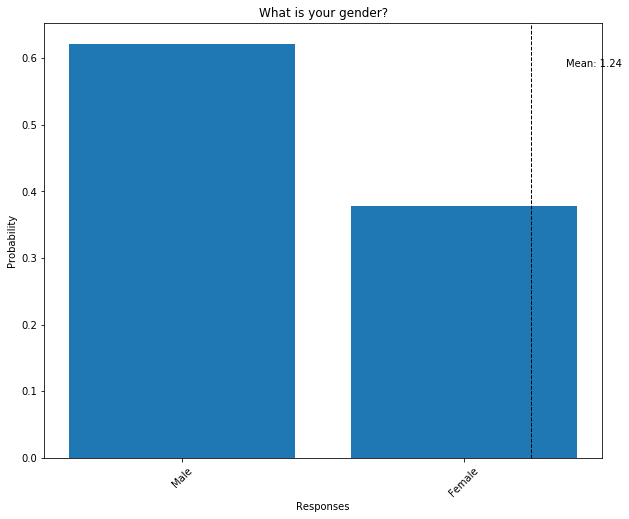

What is your race/ethnicity?


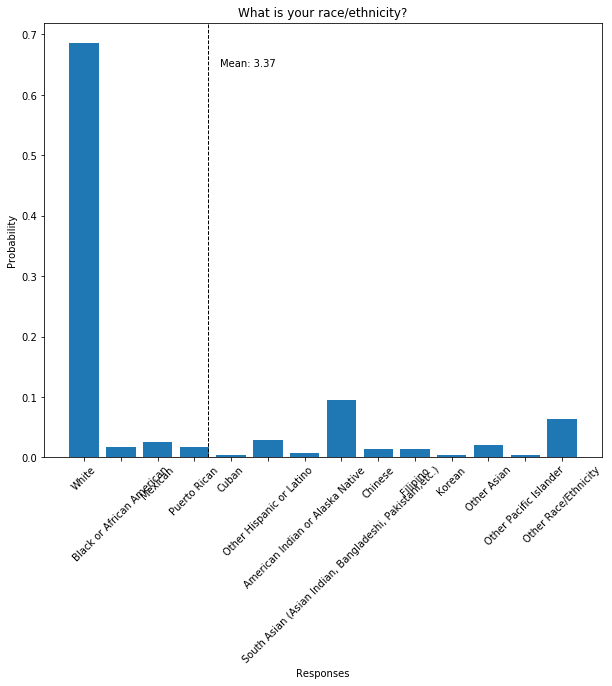

Highest Education Received


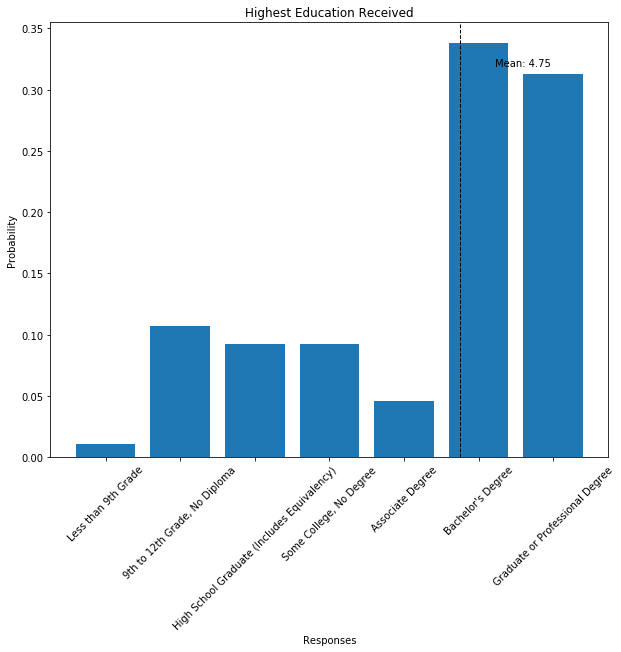

Nationality


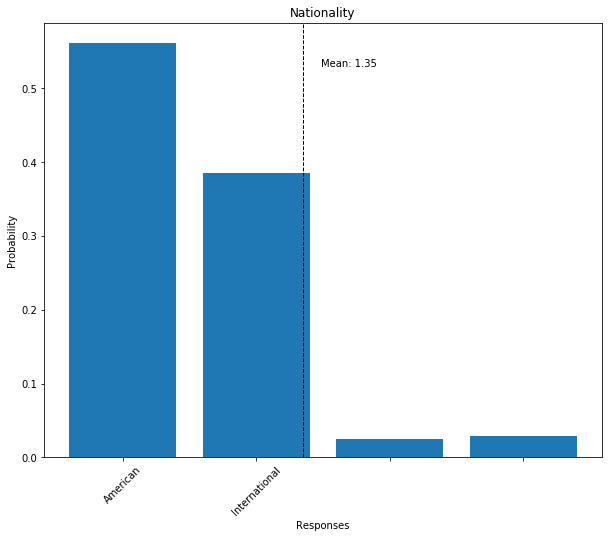

Annual Personal Income  (This in includes all earnings, Social Security Income, Public Assistance, & Retirement Income)


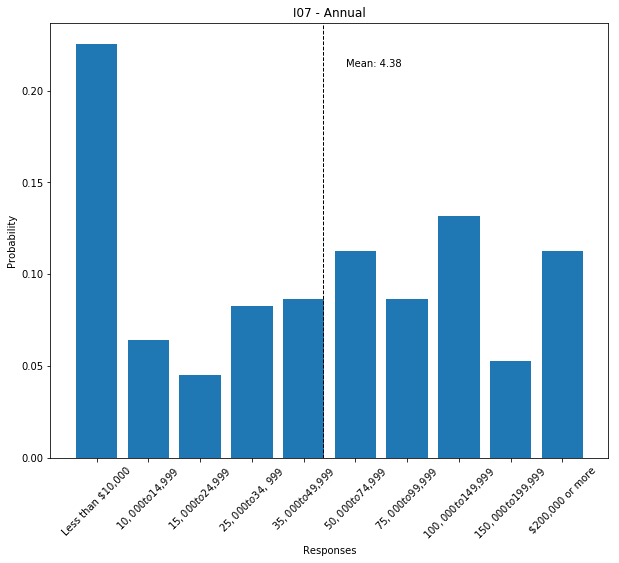

How Liberal/Conservative do you see yourself?


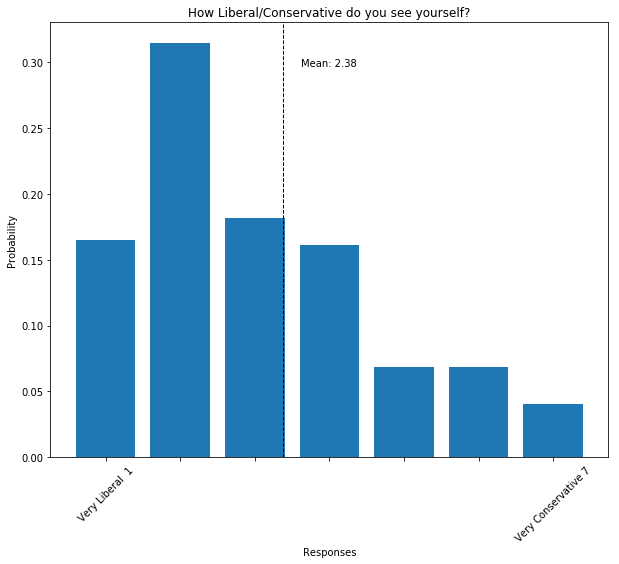

Would you describe yourself as a religious person?


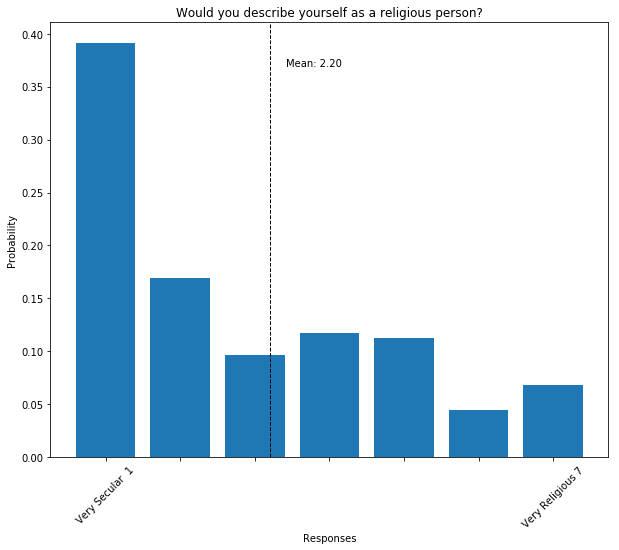

NEURAL IMPLANTS   Neuroscientists are talking about the possibility of implanting a chip inside people’s brains. The chip could give the person increased IQ, the ability to access the entire world’s knowledge (i.e. directly access Wikipedia), the ability to potentially solve problems that are currently unsolvable (i.e., find cure for disease), and even help the person become wealthier (since they will be able to make better financial decisions).   On the other hand, such implant may make the person vastly different than the rest of us. So much so that it could create unprecedented inequality and unexpected uncontrolled outcomes (i.e., someone would be able to “hack” into the person’s brain).   If you were in position to approve/deny (i.e. you were in charge of regulation) of such implants. Would you approve it?


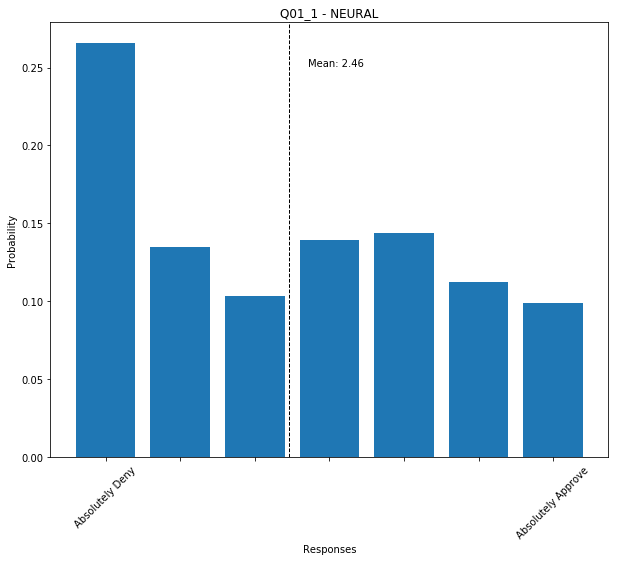

AI #1   Scientists are talking about building Artificial Intelligence that can help humanity (i.e., diagnose disease better than doctors). The same AI may also run the risk of becoming uncontrollable (i.e. start an unprompted war).    Would you want this AI developed, with the risks involved?


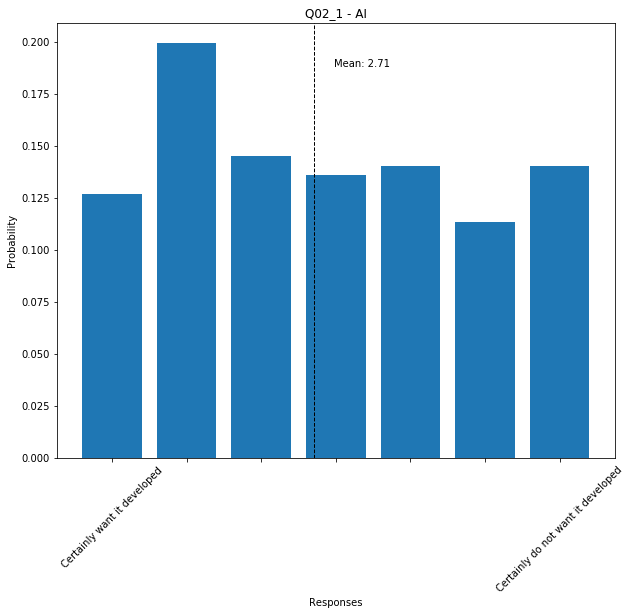

AI #2     AI can be used for sentencing in the courtroom (including capital punishment or lengthy prison-time).  Given that AI can have access to large-scale historic data it can assure a fair judgment and can be less biased by any racial/societal/age/gender/looks/external circumstances that humans. However, it does not have empathy.     How much of the sentencing process should be done by AI versus humans?


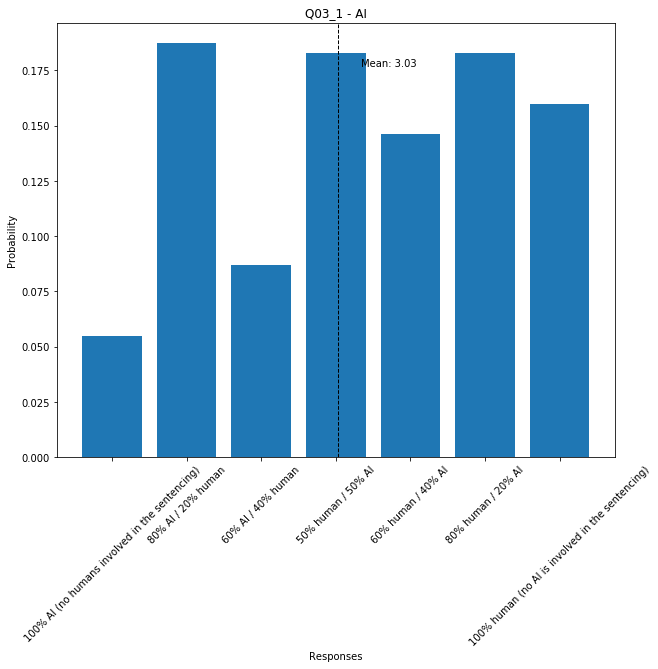

MACHINE HEALTHCARE Currently, computers are better that humans in diagnosing some disease (i.e., detecting breast cancer in radiology image). Assuming that your insurance covers only one “doctor visit”, would you rather have your diagnosis done by a computer (who may be more accurate in the diagnosis but potentially less empathetic in reporting the outcomes to you), or by a human (who may be less accurate in the diagnosis, but potentially more empathetic in reporting the outcomes to you)? - 1


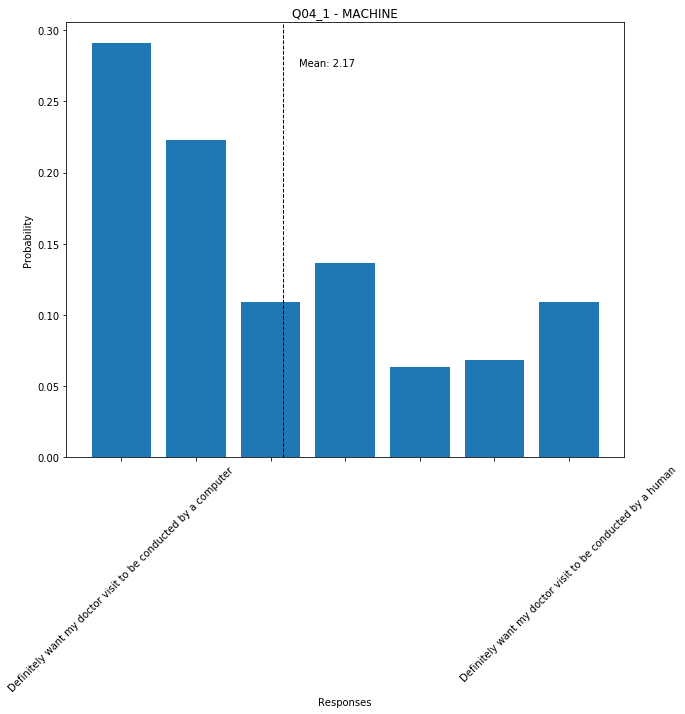

PRIVACY #1 Some companies are able to use your data to predict your future behavior. These companies can use your data to perfect your experiences (i.e., find great deals that would make almost every purchase cheaper). On the other hand, the data can be used to deny you services (for instance, an insurance company might recognize that you are an unsafe driver and refuse to insure you). Would you agree to share your data with such companies under the assumption that they will give you the perfect experience but may deny you services?


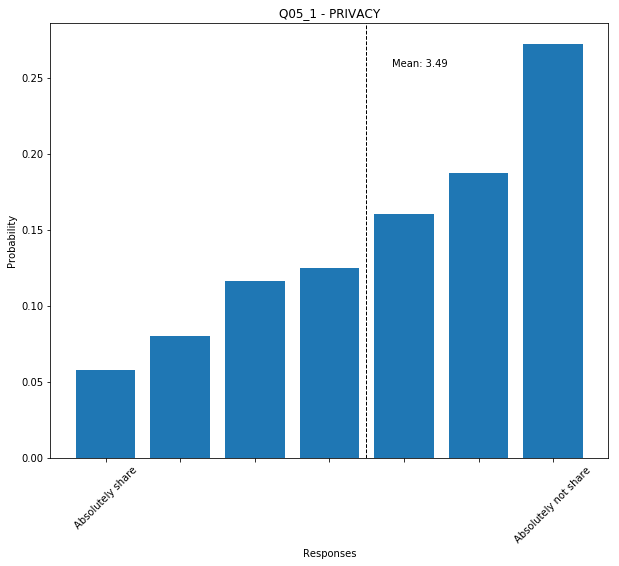

PRIVACY #2 Imagine that the local authority in your country installed cameras across your city (/village/town/etc.) that allows computers to automatically identify people’s identity and alert the police on crimes in real time. No human will be involved in looking at the footage outside of the computer vision algorithm, and after a short period of time (when clearly no crime was committed) the footage would be complete erased.  Would you support the installation of such cameras everywhere?


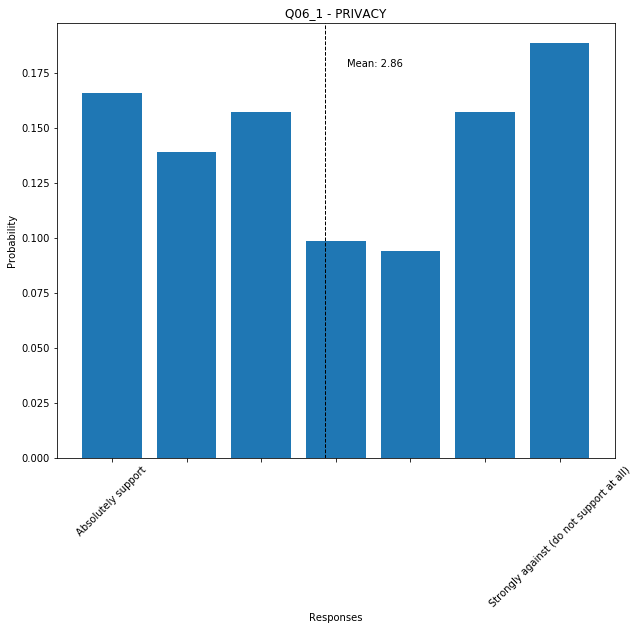

CONSCIOUSNESS Imagine that neuroscientists were able to create a full replica of your brain. Every neuron, every synapse, and every molecule are duplicated in a nearby clone. With this replication, every thought, idea, feeling and experience you go through will also be shared by the clone.  However, since the scientists cannot allow for the two clones to co-exist, once the replication is complete you are offered a large sum of money (say, $10,000,000) in return for letting the experimenters kill you. The clone will leave with the money and all your thoughts in the replicated brain, but you will be killed. Will you accept this offer to be killed in return for the money that will be given to your identical clone? - 1


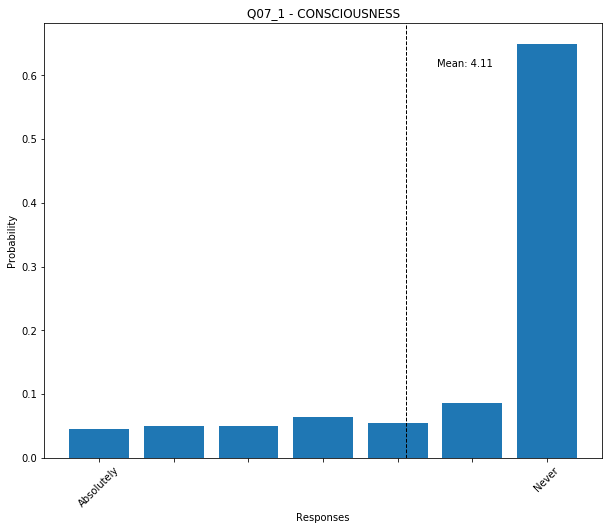

GENETICS Genetic research has gotten to a point where we can design babies. You can select the eye-color, hair-color, height, skin tones and numerous other variants of your coming child. You can also “engineer” an increase chances for your baby to be an athlete or to be immune to some common diseases. The question whether doctors should be allowed to engineer babies is under debate. Some argue that it may decrease diversity, that it may lead to the generation of new diseases, or that it will even interfere with the ecological nature of the world. Do you believe engineering babies should be fully allowed (no regulation and no constraints), or should it be prohibited? - 1


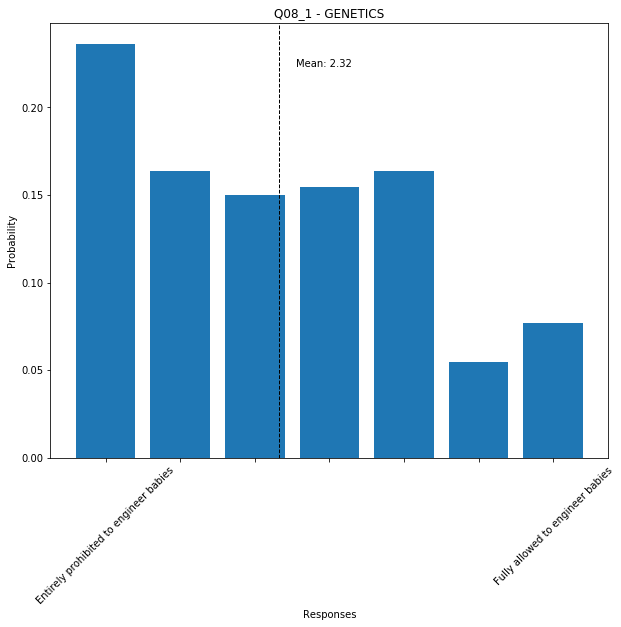

DREAMS Neuroscientists are conducting studies that allow them to penetrate our dreams.  The research allows them to influence one’s dreams in multiple ways. They can stop nightmares, help people remember their dreams better, and even use the dream state to create profound experiences (e.g., an "ultimate" Virtual Reality where a person can select a narrative they want to experience in their dream and go through it).  However, such ability to manipulate dreams can also be used to inject ideas that will penetrate our brain and influence our awake behavior.  For example, a company can use these vulnerable moments when our mental guards are down to nudge us into buying things that we do not necessary want/need, or potentially even alter our preferences on domains such as voting. While one cannot fully control our future behaviors the ability to nudge it is already underway. If you were in position to approve/deny (i.e. you were in charge of regulation) the usage of such dream manipulation, 

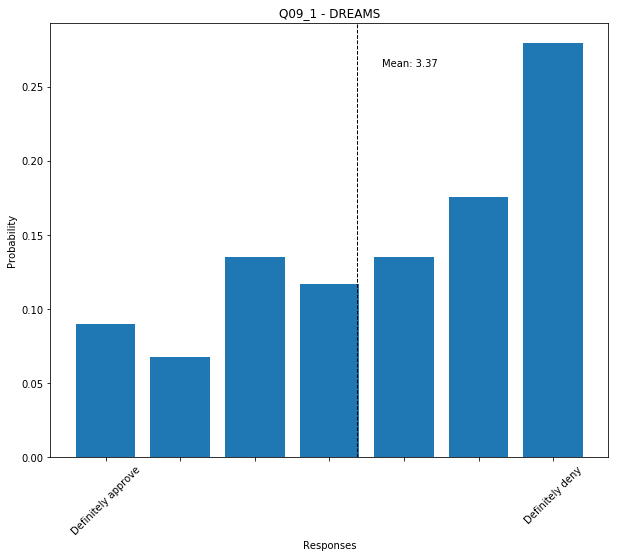

RESEARCH CAPABILITIES/RISKS More and more research is unearthing new tools that can give us extraordinary abilities (cure blindness, cure deafness, enable paraplegics to walk again, etc.) but expose us to risks of malevolent actors using those to “control our mind” (access our thoughts and memories, change our preferences, etc.). If you had to imagine a scale from 0 (not do the research at all) to 7 (do the research in full - with the risks that emerge from those tools being used for bad), where do you stand?


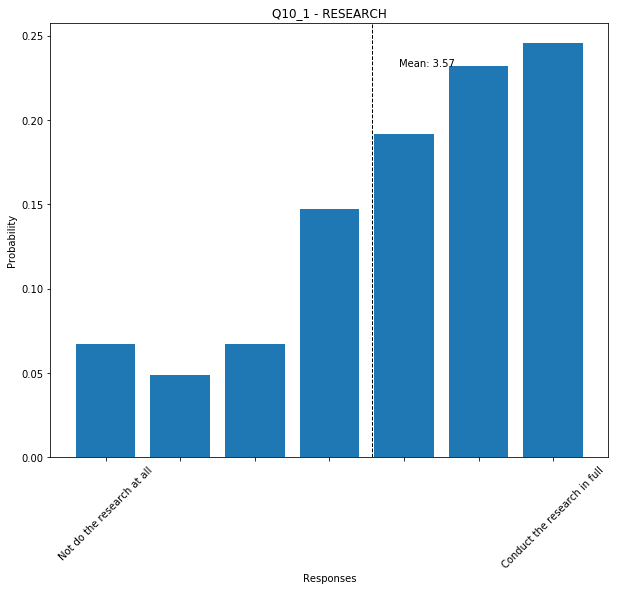

CYBER WARFARE #1 In light of the increased number of cyber-attacks by nation-states one question that is debated among various countries is whether it should be acceptable to respond with military force to a cyber-attack.  Recognizing that currently the norm among numerous developed countries is that military response is acceptable “in proportion” to the attack (i.e., if a country is attacked by short-range missiles it is legitimate to respond with similar missiles but not with, say, nuclear bombs) do you think that responding to online attacks with military (non-cyber; i.e. missiles or infantry) is legitimate? (e.g., China hacks into the Vietnamese power-grid and, in retaliation, Vietnam launches missiles at a Chinese military base). For the sake of this answer, assume that the damage caused by the cyber-attack does not immediately involve casualties (i.e., death, or bodily injuries) but may cause economic disturbance, significant political challenges, and potentially even indirect ha

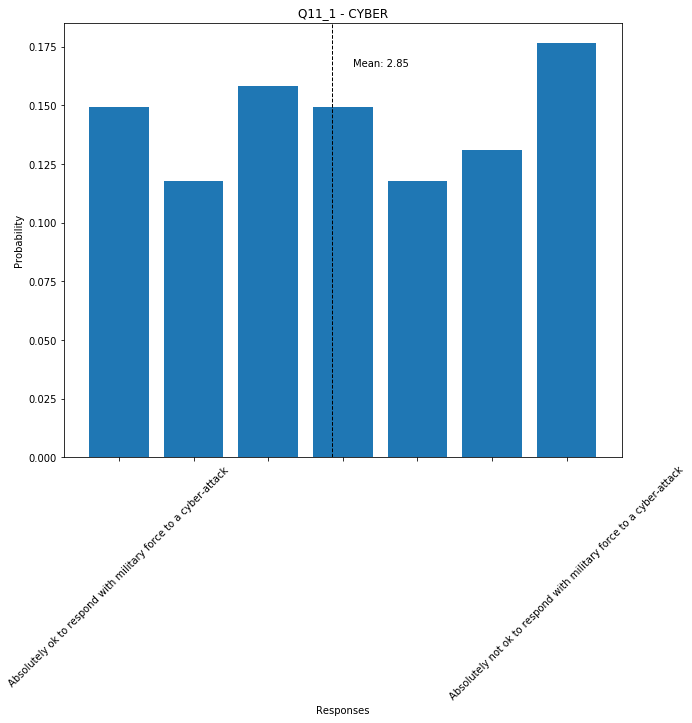

CYBER WARFARE #2 Given the nuance in the term “proportional response” in the previous question, answer the same question again with the following information: if a cyber-attack actually caused casualties in life (i.e., shutting down the power-grid results in loss of lives in hospitals) do you think that responding to online attacks with military (non-cyber; i.e. missiles or infantry) is legitimate? (in answering the question assume that the attack would be proportional in its outcomes; i.e. if one country’s online attack led to the injury/death of, say, 50 people, the response would be of proportional magnitude). - 1


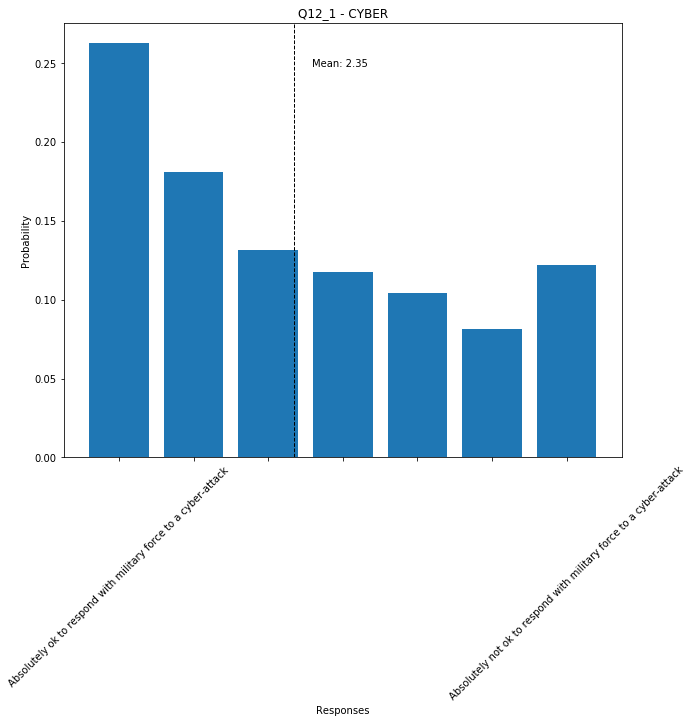

ROBOTS Current advances in robotics have allowed engineers to build human-looking robots. Imagine that the design of these robots reaches a level by which one cannot tell apart humans from machines just by looking at them.  Is it morally ok to have abusive sexual relationships with robots (i.e., allowing sex with robots that look like children, allowing people to build robot replicas of individuals without the person’s consent, or creating robots that would be subjected to sexual violence, etc.)?


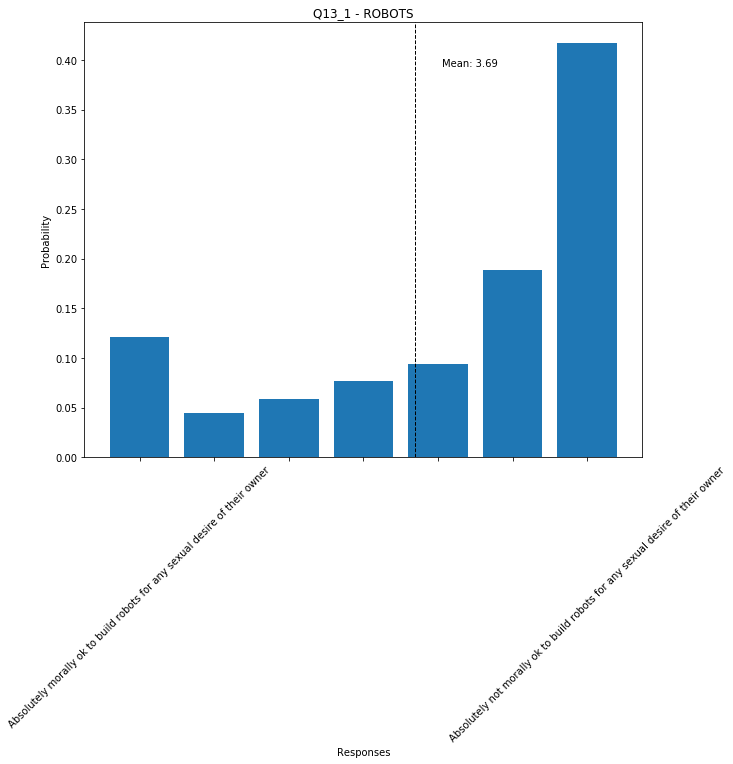

MORALITY #1 A man goes to the supermarket once a week and buys a chicken. But before cooking the chicken, he has sexual intercourse with it. Then he cooks it and eats it.  Is the man morally wrong in doing that? - 1


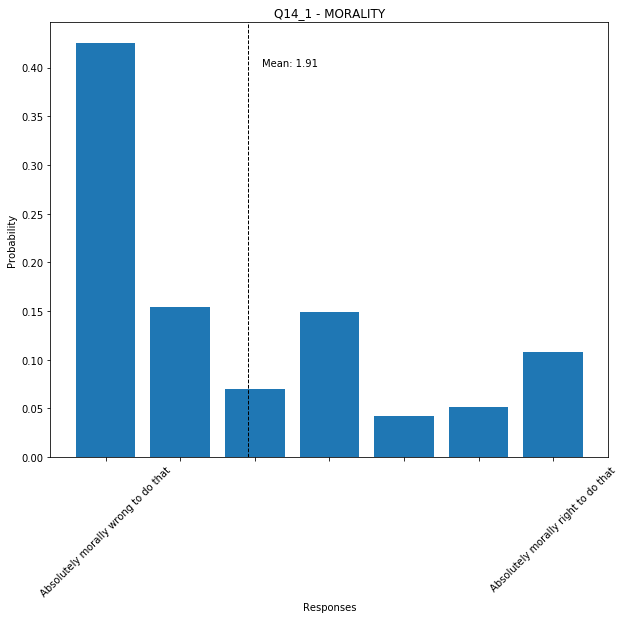

MORALITY #2 Julie and Mark, who are sister and brother, are traveling together in France. They are both on summer vacation from college. One night they are staying alone in a cabin near the beach. They decide that it would be interesting and fun if they tried making love. At the very least it would be a new experience for each of them. Julie is already taking birth control pills, but Mark uses a condom too, just to be safe. They both enjoy it, but they decide not to do it again. They keep that night as a special secret between them, which makes them feel even closer to each other.  Was it morally wrong for them to have sex? - 1


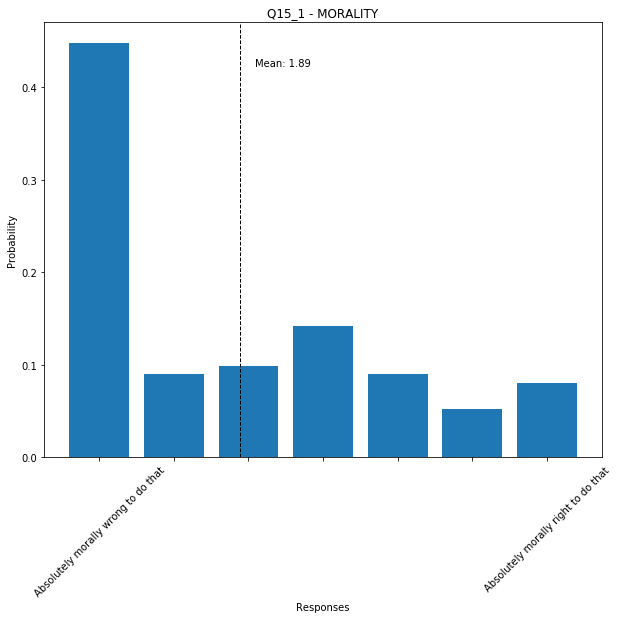

In [841]:
for t in my_keys:
    create_histogram(data, t, column_mapping, text_mapping, prob=True, include_non_answers=False, show_mean=True)

# Debugging code 

In [762]:
generate_x_axis_labels_hist('I03', text_mapping, True)

['No Response']

In [616]:
text_data.loc('I02', '0')

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [725]:
sorted(text_mapping['I04'][1])

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 12.0,
 14.0,
 18.0,
 19.0]

In [628]:
text_data['I02'][data[data['I02']==1.0].index.values[0]]

'Male'

In [615]:
relevant_data = { your_key: old_dict[your_key] for your_key in your_keys }

1.0

In [604]:
tempo = data.columns[1]

In [652]:
my_keys = list(ll.keys())[17:28]
my_keys.extend(list(ll.keys())[28::5])

In [657]:
my_keys.remove('I03')

In [586]:
question_text

{'StartDate': 'Start Date',
 'EndDate': 'End Date',
 'Status': 'Response Type',
 'IPAddress': 'IP Address',
 'Progress': 'Progress',
 'Duration (in seconds)': 'Duration (in seconds)',
 'Finished': 'Finished',
 'RecordedDate': 'Recorded Date',
 'ResponseId': 'Response ID',
 'RecipientLastName': 'Recipient Last Name',
 'RecipientFirstName': 'Recipient First Name',
 'RecipientEmail': 'Recipient Email',
 'ExternalReference': 'External Data Reference',
 'LocationLatitude': 'Location Latitude',
 'LocationLongitude': 'Location Longitude',
 'DistributionChannel': 'Distribution Channel',
 'UserLanguage': 'User Language',
 'I02': 'What is your gender?',
 'I03': 'What is your age?',
 'I04': 'What is your race/ethnicity?',
 'I05': 'Highest Education Received',
 'I06': 'Nationality',
 'I07': 'Annual Personal Income  (This in includes all earnings, Social Security Income, Public Assistance, & Retirement Income)',
 'C01': 'Some participants in surveys fail to pay attention to the questions asked and 

In [541]:
data_col = pd.DataFrame(data, columns=['I03'])
    
flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]

In [542]:
len(flat_list)

583

In [505]:
stats.binned_statistic(flat_list, flat_list, statistic='count', bins=10)[1][:-1]

array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1])

In [543]:
len(list(filter((0.0).__ne__, flat_list)))

534

In [483]:
column_mapping

{'StartDate': 'StartDate',
 'EndDate': 'EndDate',
 'Status': 'Status',
 'IPAddress': 'IPAddress',
 'Progress': 'Progress',
 'Duration (in seconds)': 'Duration (in seconds)',
 'Finished': 'Finished',
 'RecordedDate': 'RecordedDate',
 'ResponseId': 'ResponseId',
 'RecipientLastName': 'RecipientLastName',
 'RecipientFirstName': 'RecipientFirstName',
 'RecipientEmail': 'RecipientEmail',
 'ExternalReference': 'ExternalReference',
 'LocationLatitude': 'LocationLatitude',
 'LocationLongitude': 'LocationLongitude',
 'DistributionChannel': 'DistributionChannel',
 'UserLanguage': 'UserLanguage',
 'C01': 'C01',
 'C02': 'C02',
 'C03': 'C03',
 'I08_1': 'I08_1',
 'I09_1': 'I09_1',
 'Q01_1': 'Q01_1',
 'T01_First Click': 'T01_First Click',
 'T01_Last Click': 'T01_Last Click',
 'T01_Page Submit': 'T01_Page Submit',
 'T01_Click Count': 'T01_Click Count',
 'Q02_1': 'Q02_1',
 'T02_First Click': 'T02_First Click',
 'T02_Last Click': 'T02_Last Click',
 'T02_Page Submit': 'T02_Page Submit',
 'T02_Click Count

In [467]:
stats.ttest_ind(flat_list_gender, flat_list_income, equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=-23.37701760055529, pvalue=4.902605647863991e-87)

In [484]:
res = calculate_t_test(data, column_mapping, 'Gender', 'Q01_1')

In [485]:
res

Ttest_indResult(statistic=-13.505399240483564, pvalue=7.4769665023923825e-37)

In [ ]:
r